In [1]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math
import os
import re
import requests
import pathlib
import tspex

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests as r
import seaborn as sns
import xml.etree.ElementTree as ET

from Bio import SeqIO
from io import StringIO
from IPython.display import Image
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
ASSAY_LIST_PATH = "assay-list-olink-explore-3072.xlsx"
brain_rna_seq_path = "fe-wp-dataset-124.csv"
PLATE_LAYOUT_PATH = "Plate Layout.xlsx"
raw_data_path = "LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
UNIPROT_TO_FASTA_PATH = "uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"

In [3]:
plate_layout = pd.read_excel(PLATE_LAYOUT_PATH)

In [4]:
assays = pd.read_excel(ASSAY_LIST_PATH)

# uniprot_ids = []
# fasta_sequences = []

# assay_ids = list(assays["UniProt ID"])
# uniprot_ids = []
# fasta_sequences = []
# for cID in assay_ids:
#     baseUrl="http://www.uniprot.org/uniprot/"
#     currentUrl=baseUrl+cID+".fasta"
#     response = r.post(currentUrl)
#     cData=''.join(response.text)
#     uniprot_id = re.search(r'\|([^|]+)\|', cData)
#     if match:
#         uniprot_ids.append(uniprot_id.group(1))
#     fasta = cData.split('\n', 1)
#     if len(fasta) > 1:
#         fasta_sequences.extend(fasta[1].split('|'))
# formatted_fasta_sequences = [item.replace('\n', '') for item in fasta_sequences]

In [5]:
# Map UniProt IDs to the corresponding FASTA sequences
def parse_gz_file(file_path):
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""
    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence
    return protein_dict

In [6]:
def tmhmm_localization(assays, output_directory):
    deeptmhmm = biolib.load("DTU/DeepTMHMM")
    with open("query.fasta", "w") as fasta_file:
        for _, row in assays.iterrows():
            fasta_line = f">{row['UniProt ID']}\n{row['Sequence']}\n"
            fasta_file.write(fasta_line)
        deeptmhmm_job = deeptmhmm.cli(args="--fasta query.fasta", machine="local")
        deeptmhmm_job.save_files(output_directory)


def identify_localization(assays, region, output_directory="olink_output"):
    """
    Parameters
    ----------
    assays : pandas.DataFrame
        DataFrame with columns called 'UniProt ID' and 'Sequence'
    region : {'TMhelix', 'inside', 'outside', 'internal'}
        Subcellular region requested. Options:
          - 'TMhelix': transmembrane proteins
          - 'inside': at least some of the protein is inside the cell/EV
          - 'outside': at least some of the protein is outside the cell/EV
          - 'internal': the protein is only found inside the cell, no transmembrane or outside domains
          - 'external': the protein is only found outside the cell, no transmembrane or inside domains
    """
    output_directory_path = pathlib.Path(output_directory)
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    # os.chdir(output_directory)
    if not os.path.exists(output_directory_path / "TMRs.gff3"):
        tmhmm_localization(assays, output_directory_path)
    localization_df = pd.read_csv(
        output_directory_path / "TMRs.gff3",
        sep="\t",
        comment="#",
        names=[
            "uniprot_id",
            "region_location",
            "region_start",
            "region_end",
            0,
            1,
            2,
            3,
        ],
    )
    localization_df = localization_df[localization_df["uniprot_id"] != "//"].dropna(
        axis=1
    )
    get_regional_uniprots = lambda region: set(
        localization_df[localization_df["region_location"] == region]["uniprot_id"]
    )
    if region == "internal":
        tm_uniprots = get_regional_uniprots("TMhelix")
        outside_uniprots = get_regional_uniprots("outside")
        inside_uniprots = get_regional_uniprots("inside")
        return inside_uniprots - tm_uniprots - outside_uniprots
    if region == "external":
        tm_uniprots = get_regional_uniprots("TMhelix")
        outside_uniprots = get_regional_uniprots("outside")
        inside_uniprots = get_regional_uniprots("inside")
        return outside_uniprots - inside_uniprots - tm_uniprots
    else:
        return get_regional_uniprots(region)


In [7]:
def calculate_mean(df):
    return df.assign(Mean=df.mean(axis=1, numeric_only=True))


def map_hgnc_ids(brain_rna_seq_path):
    
    hgnc_ids = (
        "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
    )
    brain_rna_seq = pd.read_csv(brain_rna_seq_path)

    hgnc_uniprot_mapping_data = pd.read_csv(
        (StringIO(requests.get(hgnc_ids).text)),
        sep="\t",
        usecols=["hgnc_id", "uniprot_ids"],
    )
    brain_rna_seq = pd.merge(
        brain_rna_seq,
        hgnc_uniprot_mapping_data,
        left_on="id",
        right_on="hgnc_id",
        how="inner",
    )
    brain_rna_seq.dropna(subset=["uniprot_ids"], inplace=True)
    brain_rna_seq.drop_duplicates(subset=["uniprot_ids"], inplace=True)

    return brain_rna_seq

def mean_cell_type(brain_rna_seq_data, cell_type):
    """
    Returns only the mean of the data for the specified cell type, as well as the UniProt ID information in an additional column
    Parameters
    ----------
    brain_rna_seq_data : pandas.DataFrame
        Dataframe with a column called "uniprot_ids" (contains UniProt ID), and other columns containing cell-type specific Brain RNA Seq data
    cell_type : {'fetal', 'mature', 'endothelial', 'microglia', 'oligodendrocyte', 'neuron'}
        Cell type of interest requested. Options:
         - 'astrocyte': mature astrocytes
         - 'endothelial': endothelial cells
         - 'microglia': microglia cells
         - 'oligodendrocyte': oligodendrocytes
         - 'neuron': neurons
    """
    if cell_type == "microglia":
        microglia_df = calculate_mean(
            brain_rna_seq_data[
                brain_rna_seq_data.filter(like="microglla").columns.append(
                    pd.Index(["uniprot_ids"])
                )
            ]
        )[["uniprot_ids", "Mean"]]
        return microglia_df.rename(
            columns={"uniprot_ids": "uniprot_ids", "Mean": "microglia"}
        )
    if cell_type == "astrocyte":
        astrocyte_df = calculate_mean(
            brain_rna_seq_data[
                brain_rna_seq_data.filter(like="mature").columns.append(
                    pd.Index(["uniprot_ids"])
                )
            ]
        )[["uniprot_ids", "Mean"]]
        return astrocyte_df.rename(
            columns={"uniprot_ids": "uniprot_ids", "Mean": "astrocyte"}
        )
    else:
        cell_type_df = calculate_mean(
            brain_rna_seq_data[
                brain_rna_seq_data.filter(like=cell_type).columns.append(
                    pd.Index(["uniprot_ids"])
                )
            ]
        )[["uniprot_ids", "Mean"]]
        return cell_type_df.rename(
            columns={"uniprot_ids": "uniprot_ids", "Mean": cell_type}
        )


def cell_type_enrichment(
    brain_rna_seq_data,
    cell_type,
    indiv_specificity_metric,
    indiv_specificity_cutoff,
    general_specificity_metric="none",
    general_specificity_cutoff="none",
):
    """
    Parameters
    ----------
    brain_rna_seq_data : pandas.DataFrame
        Dataframe with a column called "uniprot_ids" (contains UniProt ID), and other columns containing cell-type specific Brain RNA Seq data for the cell types listed under cell_type
    cell_type : {'fetal', 'mature', 'endothelial', 'microglia', 'oligodendrocyte', 'neuron'}
        Cell type of interest requested. Options:
         - 'astrocyte': mature astrocytes
         - 'endothelial': endothelial cells
         - 'microglia': microglia cells
         - 'oligodendrocyte': oligodendrocytes
         - 'neuron': neurons
    general_specificity_metric : {
        'tau',
        'counts',
        'gini',
        'simpson',
        'shannon_specifity',
        'roku_specificity',
        'spm_dpm',
        'js_specificity_dpm',
    }
        Primary metric of determining cell-type specificity requested. Options:
        - 'tau': tau score
        - 'counts': counts
        - 'gini': gini coefficient
        - 'simpson': simpson index
        - 'shannon_specificity': shannon entropy specificity (HS)
        - 'roku_specificity': ROKU specificity
        - 'spm_dpm': specificity measure dispersion (SPM DPM)
        - 'js_specificity_dpm': jensen-shannon specificity dispersion (JSS DPM)
        - 'none': default, no general specificity metric requested
    indiv_specificity_metric: {
        'tsi',
        'zscore',
        'spm',
        'js_specificity'
    }
        Secondary metric of determining cell type specificity requested. Options:
        - 'tsi': tissue specificity index
        - 'z-score': z-score
        - 'spm': specificity measure
        - 'js_specificity': jensen-shannon specificity
    general_specificity_cutoff : numeric
        Numeric value representing the minimum value of the first enrichment cutoff.
        Default = none
    indiv_specificity_cutoff : numeric
        Numeric value representing the minimum value of the second enrichment cutoff.
    """
    astrocytes = mean_cell_type(brain_rna_seq_data, "astrocyte")
    endothelial = mean_cell_type(brain_rna_seq_data, "endothelial")
    microglia = mean_cell_type(brain_rna_seq_data, "microglia")
    oligodendrocytes = mean_cell_type(brain_rna_seq_data, "oligodendrocyte")
    neurons = mean_cell_type(brain_rna_seq_data, "neuron")

    all_cell_types = pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(astrocytes, endothelial, on="uniprot_ids"),
                microglia,
                on="uniprot_ids",
            ),
            oligodendrocytes,
            on="uniprot_ids",
        ),
        neurons,
        on="uniprot_ids",
    )
    all_cell_types.set_index("uniprot_ids", inplace=True)

    expression_data = all_cell_types.loc[
        :, ["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"]
    ]
    expression_data = expression_data.loc[(expression_data > 0).any(axis=1)]

    if general_specificity_metric == "none":
        tso_indiv = tspex.TissueSpecificity(
            expression_data, indiv_specificity_metric, log=True
        )
    else:
        tso_gen = tspex.TissueSpecificity(
            expression_data, general_specificity_metric, log=True
        )
        tso_gen_df = pd.DataFrame(
            tso_gen.tissue_specificity, columns=["general_specificity_metric"]
        )
        tso_gen_filtered = list(
            tso_gen_df[
                tso_gen_df["general_specificity_metric"] > general_specificity_cutoff
            ].index
        )
        tso_gen_filtered_df = expression_data.loc[tso_gen_filtered]

        tso_indiv = tspex.TissueSpecificity(
            tso_gen_filtered_df, indiv_specificity_metric, log=True
        )

    tso_indiv_df = pd.DataFrame(
        tso_indiv.tissue_specificity,
        columns=["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"],
    )
    cell_type_uniprot_ids = tso_indiv_df[
        tso_indiv_df[cell_type] > indiv_specificity_cutoff
    ].index.tolist()
    return cell_type_uniprot_ids

In [8]:
def clean_up_raw_olink_file(raw_data_path, plate_layout_dataframe):
    unimportant_columns = [
        "Index",
        "OlinkID",
        "Panel_Lot_Nr",
        "PlateID",
        "WellID",
        "Normalization",
        "Processing_StartDate",
        "Processing_EndDate",
        "AnalyzerID",
        "ExploreVersion",
    ]

    panels = [
        "Cardiometabolic",
        "Cardiometabolic_II",
        "Inflammation",
        "Inflammation_II",
        "Neurology",
        "Neurology_II",
        "Oncology",
        "Oncology_II",
    ]
    
    raw_data = pd.read_csv(raw_data_path, sep=";")
    raw_data.drop(unimportant_columns, axis=1, inplace = True)

    data = pd.merge(raw_data, plate_layout_dataframe, how="left", on="SampleID")

    # Normalize the data according to plate negative controls
    ctrl_dict = {}
    for panel in panels:
        df = data[(data["Panel"] == panel)]
        plate_ctrl = df[
            (df["Sample_Type"] == "PLATE_CONTROL")
            & (df["Assay"] == "Amplification control 1")
        ]["NPX"].median()
        ctrl_dict[panel] = plate_ctrl
    data["Delta"] = data.apply(
        lambda row: row["NPX"] - ctrl_dict[row["Panel"]],
        axis=1,
    )

    # Linearize the NPX values
    data["Linear Delta"] = data["Delta"].map(lambda x: 2**x)

    # Identify and drop replicate assays
    vc = data[["SampleID", "Sample_Type", "UniProt"]].value_counts()
    vc = vc[vc > 1]

    unique_uniprot_values = vc.index.get_level_values("UniProt").unique()
    uniprot_list = unique_uniprot_values.tolist()

    raw_data_no_reps = data[~data["UniProt"].isin(uniprot_list)].copy()
    for index, row in raw_data_no_reps.iterrows():
        if row["NPX"] < row["LOD"]:
            raw_data_no_reps.at[index, "NPX"] = row["LOD"]

    # Create a tidy dataframe for the delta values
    tidy_data = raw_data_no_reps[raw_data_no_reps["Sample_Type"] == "SAMPLE"].pivot(
        columns="UniProt", index=["SampleID", "Health", "Sample", "CSF_sample"], values="Linear Delta"
    )
    return tidy_data

In [9]:
def analyze_fractionation(tidy_dataframe, high_fractions, low_fractions, sample_health = "all", mean_median_individual = "individual"):
    """
    Parameters
    ----------
    'tidy_dataframe' : pandas.DataFrame
        DataFrame with one column for each assay, one row for each sample, linearized NPX as the vlaues, and the following indices:
            - 'SampleID'
            - 'Health'
            - 'Sample'
            - 'CSF_sample'
    'high_fractions' : list of strings
        Fractions that should be higher than the fractions in the list of low fractions.
    'low_fractions' : list of strings
        Fractions that should be lower than the fractions in the list of high fractions.
    'sample_health' : {'all', 'ad', 'mci', 'mci_spectrum'}
        Health of the sample requested. Options: 
            - 'healthy': only samples from healthy individuals
            - 'all': all different health groups
            - 'ad': samples from individuals diagnosed with Alzheimer's Disease (AD)
            - 'mci': samples from individuals diagnosed with mild cognitive imapirment that has not yet progressed to AD
            - 'mci_spectrum': samples from individuals diagnosed with mild cognitive impairment and samples from individuals that have been diagnosed with AD
    'mean_median_individual' : {'mean', 'median', 'individual'}
        How the groups of samples should be analyzed. Options: 
            - 'mean': the means of each fraction should be compared against each other
            - 'median': the medians of each fraction should be compared against each other
            - 'individual': the fractions of each sample should be compared against each other with no aggregation/grouping 
            - 'individual_median': for each fraction, the median value of all samples will be compared
            - 'individual_mean': for each fraction, the mean value of all samples will be compared
        Default value: 'individual'
    """
    
    non_ppa_data = tidy_dataframe[tidy_dataframe.index.get_level_values("Sample").str.contains("SEC")]

    if sample_health == 'healthy': 
        requested_health_data = non_ppa_data[non_ppa_data.index.get_level_values("Health").str.contains('Healthy')]
    if sample_health == 'all': 
        requested_health_data = non_ppa_data
    if sample_health == 'ad': 
        requested_health_data =  non_ppa_data[non_ppa_dat.index.get_level_values("Health").str.contains('AD')]
    if sample_health == 'mci':
        requested_health_data =  non_ppa_data[non_ppa_dat.index.get_level_values("Health").str.contains('MCI')]
    if sample_health == 'mci_spectrum': 
        requested_health_data = non_ppa_data[
            (non_ppa_data.index.get_level_values("Health").str.contains('AD'))
            | (non_ppa_data.index.get_level_values('Health').str.contains('MCI'))
        ]

    high_fractions_dataframes = {}
    for fraction in high_fractions:
        high_fractions_dataframes[fraction] = requested_health_data[requested_health_data.index.get_level_values("Sample").str.contains(fraction)]
    high_fractions_df = pd.concat(high_fractions_dataframes.values(), axis = 0)
    low_fractions_dataframes = {}
    for fraction in low_fractions: 
        low_fractions_dataframes[fraction] = requested_health_data[requested_health_data.index.get_level_values("Sample").str.contains(fraction)]
    low_fractions_df = pd.concat(low_fractions_dataframes.values(), axis=0)

    correct_fractionation = []
  
    for assay in list(non_ppa_data.columns):
        if mean_median_individual == "median":
            if not high_fractions_df[assay].isna().all():
                high_fractions = high_fractions_df[assay].median()
            if not low_fractions_df[assay].isna().all():
                low_fractions = low_fractions_df[assay].median()
            if high_fractions > low_fractions: 
                correct_fractionation.append(assay)
        if mean_median_individual == "mean":
            if not high_fractions_df[assay].isna().all():
                high_fractions = high_fractions_df[assay].mean()
            if not low_fractions_df[assay].isna().all():
                low_fractions = low_fractions_df[assay].mean()
            if high_fractions > low_fractions: 
                correct_fractionation.append(assay)
        if mean_median_individual == "individual":
            for sample in list(requested_health_data.index.get_level_values("CSF_sample").unique()):
                high_sample_data = high_fractions_df[high_fractions_df.index.get_level_values("CSF_sample") == sample]
                low_sample_data = low_fractions_df[low_fractions_df.index.get_level_values("CSF_sample") == sample]
                if not high_sample_data[assay].isna().all():
                    high_fractions = high_sample_data[assay].min()
                if not low_sample_data[assay].isna().all():
                    low_fractions = low_sample_data[assay].max()
                if high_fractions > low_fractions: 
                    correct_fractionation.append(assay)
        if mean_median_individual == "individual_median":
            high_fractions_values = []
            for fraction in high_fractions:
                if not high_fractions_df[assay].isna().all():
                    high_fractions_values.append(high_fractions_df[high_fractions_df.index.get_level_values("Sample").str.contains(fraction)][assay].median())
            low_fractions_values = []
            for fraction in low_fractions: 
                if not low_fractions_df[assay].isna().all():
                    low_fractions_values.append(low_fractions_df[low_fractions_df.index.get_level_values("Sample").str.contains(fraction)][assay].median())
            if all(value1 > value2 for value1 in high_fractions_values for value2 in low_fractions_values):
                correct_fractionation.append(assay)
        if mean_median_individual == "individual_mean":
            high_fractions_values = []
            for fraction in high_fractions:
                if not high_fractions_df[assay].isna().all():
                    high_fractions_values.append(high_fractions_df[high_fractions_df.index.get_level_values("Sample").str.contains(fraction)][assay].mean())
            low_fractions_values = []
            for fraction in low_fractions: 
                if not low_fractions_df[assay].isna().all():
                    low_fractions_values.append(low_fractions_df[low_fractions_df.index.get_level_values("Sample").str.contains(fraction)][assay].mean())
            if all(value1 > value2 for value1 in high_fractions_values for value2 in low_fractions_values):
                correct_fractionation.append(assay)
    # return pd.Series(correct_fractionation).value_counts()
    return correct_fractionation

In [10]:
def identify_targets(correct_fractionation_uniprot_ids, cell_type_uniprot_ids, localization_uniprot_ids):
    return (set(correct_fractionation_uniprot_ids) & set(cell_type_uniprot_ids) & set(localization_uniprot_ids))

In [11]:
def identify_fractionation_pattern_cell_type_specific_targets(
    raw_olink_data_file,
    plate_layout,
    assay_dataframe, 
    uniprot_fasta_database, 
    region, 
    brain_rna_seq_path,
    cell_type, 
    general_specificity_metric, 
    general_specificity_cutoff, 
    indiv_specificity_metric, 
    indiv_specificity_cutoff,
    high_fractions,
    low_fractions,
    sample_health,
    mean_median_individual,
    output_directory = 'olink_output', 
    ):
    tidy_dataframe = clean_up_raw_olink_file(raw_olink_data_file, plate_layout)
    assays = pd.read_excel(ASSAY_LIST_PATH)

    fasta_sequences = parse_gz_file(uniprot_fasta_database)
    assays["Sequence"] = assays["UniProt ID"].map(lambda x: fasta_sequences.get(x, "N/A"))
    localization_uniprot_ids = identify_localization(assay_dataframe, region)

    brain_rna_seq = map_hgnc_ids(brain_rna_seq_path)
    cell_type_uniprot_ids = cell_type_enrichment(
        brain_rna_seq, cell_type, indiv_specificity_metric, indiv_specificity_cutoff, general_specificity_metric, general_specificity_cutoff
    )

    correct_fractionation_uniprot_ids = analyze_fractionation(tidy_dataframe, high_fractions, low_fractions, sample_health, mean_median_individual)

    return identify_targets(correct_fractionation_uniprot_ids, cell_type_uniprot_ids, localization_uniprot_ids)
    
microglia_targets = identify_fractionation_pattern_cell_type_specific_targets(
    raw_olink_data_file = raw_data_path, 
    plate_layout = plate_layout, 
    assay_dataframe = assays, 
    uniprot_fasta_database = UNIPROT_TO_FASTA_PATH, 
    region = "internal", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "microglia", 
    general_specificity_metric = "tau", 
    general_specificity_cutoff = 0.7, 
    indiv_specificity_metric = "zscore", 
    indiv_specificity_cutoff = 0.45, 
    high_fractions = ['9', '10'], 
    low_fractions = ['6', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median'
    )

In [ ]:
print(microglia_targets)

{'P23743', 'Q9Y6U3', 'P13995', 'Q8ND71', 'Q92835', 'Q01543', 'Q6P589', 'Q9NP95', 'Q8WV28', 'Q13576', 'P41218', 'P55008'}


In [ ]:
tidy_data = clean_up_raw_olink_file(raw_data_path, plate_layout)

P23743
Q01543
Q6P589
Q8WV28

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_12520\2094698226.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group[uniprot_id].values for name, group in df_sorted.groupby("Sample")


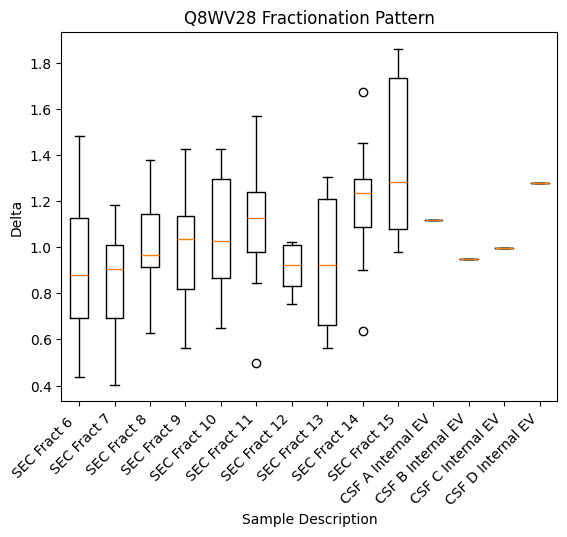

In [ ]:
graph_medians("Q8WV28")

In [ ]:
CSF_SAMPLES = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
]


def graph_medians(uniprot_id):
    df = tidy_data[uniprot_id]
    df = df.reset_index(level=["SampleID", "Health", "Sample"])

    df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)

    df_sorted = df.sort_values("Sample")

    grouped_data = [
        group[uniprot_id].values for name, group in df_sorted.groupby("Sample")
    ]

    plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)

    plt.xlabel("Sample Description")

    plt.ylabel("Delta")

    plt.title(f"{uniprot_id} Fractionation Pattern")

    plt.xticks(range(1, len(CSF_SAMPLES) + 1), CSF_SAMPLES)

    plt.xticks(rotation=45, ha="right")

    plt.show()